In [3]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [4]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')

In [5]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [6]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [7]:
zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm)

In [3]:
eta_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_eta.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_eta.zarr')
eta_filtered2 = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_eta_nom.zarr')
eta_unfiltered2 = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_eta_nom.zarr')

In [4]:
eta_f = eta_filtered.eta.isel(time=slice(1,41))
eta_un = eta_unfiltered.eta.isel(time=slice(1,41))
eta_f2 = eta_filtered2.eta.isel(time=slice(1,41))
eta_un2 = eta_unfiltered2.eta.isel(time=slice(1,41))

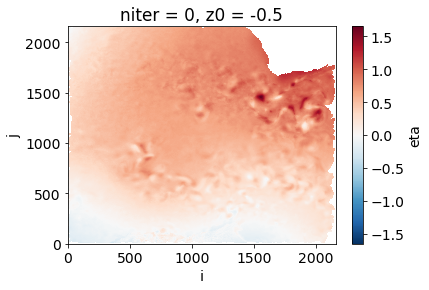

In [5]:
(eta_un.isel(time=20)-eta_un.isel(time=1)).plot(x='i')

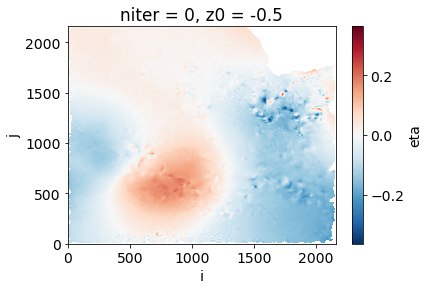

In [6]:
(eta_f.isel(time=20)-eta_f.isel(time=1)).plot(x='i')

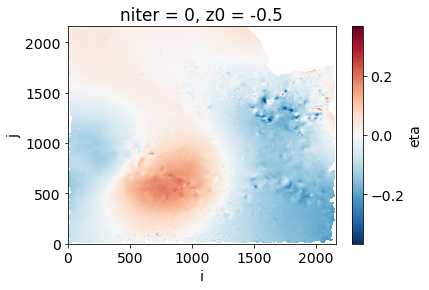

In [7]:
(eta_f2.isel(time=20)-eta_f2.isel(time=0)).plot(x='i')

In [8]:
40/24

1.6666666666666667

In [10]:
#plt.figure(figsize=(8,5))
#from matplotlib.colors import LogNorm
#for tt in range(0,40):
#    plt.clf()
#    (eta_f2.isel(time=tt)-eta_un2.isel(time=1)).rename('SSH').plot.pcolormesh(
#        x='i',y='j',levels=np.arange(-0.05,0.05,0.001),rasterized=True,cbar_kwargs={'extend':'both'})
#    plt.xlabel('Longitude')
#    plt.ylabel('Latitude')
#    plt.title('time = ' + '{0:.2f}'.format((eta_f2.time.values[tt]-eta_f2.time.values[0])/3600/24)+ 'days')
#    plt.tight_layout()
#    fig = plt.gcf()
#    fig.savefig("/home/spencerj/agulhas-offline/movie/eta2/fig{:03d}.jpg".format(tt))

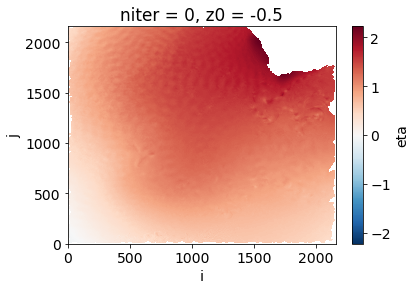

In [11]:
(eta_un2.isel(time=20)-eta_un2.isel(time=1)).plot(x='i')

In [32]:
#ffmpeg -r 60 -f image2 -i fig%03d.jpg -vcodec libx264 -crf 25 -pix_fmt yuv420p vel.mp4
plt.figure(figsize=(8,5))
from matplotlib.colors import LogNorm
for tt in range(0,41):
    plt.clf()
    eta_f2.isel(time=tt).rename('SSH').plot.pcolormesh(
        x='i',y='j',levels=np.arange(-2,2,0.05),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_f2.time.values[tt]-eta_f2.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta2/fig{:03d}.jpg".format(tt))

IndexError: Index is not smaller than dimension 40 >= 40

<Figure size 576x360 with 0 Axes>

In [34]:
#ffmpeg -r 60 -f image2 -i fig%03d.jpg -vcodec libx264 -crf 25 -pix_fmt yuv420p vel.mp4
plt.figure(figsize=(8,5))
from matplotlib.colors import LogNorm
for tt in range(0,41):
    plt.clf()
    eta_f.isel(time=tt).rename('SSH').plot.pcolormesh(
        x='i',y='j',levels=np.arange(-2,2,0.05),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_f.time.values[tt]-eta_f.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta1/fig{:03d}.jpg".format(tt))

IndexError: Index is not smaller than dimension 40 >= 40

<Figure size 576x360 with 0 Axes>

In [12]:
with ProgressBar():
    etahat_f = xrft.power_spectrum(eta_f.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()#, detrend='linear'
    etahat_f2 = xrft.power_spectrum(eta_f2.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()#, detrend='linear'

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 16.1s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 16.0s


In [13]:
spec0 = int(( etahat_f['freq_time'].size-1)/2)

Text(0.5, 0, 'Frequency (cph)')

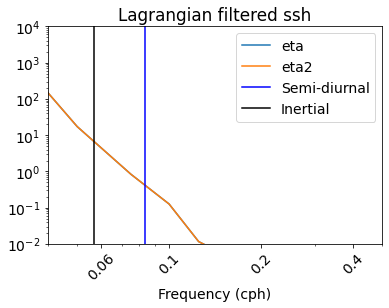

In [14]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]
plt.plot(etahat_f.freq_time[spec0:]*3600,etahat_f.mean(['i','j'])[spec0:],label='eta')
plt.plot(etahat_f2.freq_time[spec0:]*3600,etahat_f.mean(['i','j'])[spec0:],label='eta2')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered ssh')
plt.ylim(10**-2,10**4)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

In [15]:
eta_filt = eta_f.assign_coords(x0=("i", eta_f.x0.values)).swap_dims({"i": "x0"})
eta_filt = eta_filt.assign_coords(y0=("j", eta_f.y0.values)).swap_dims({"j": "y0"})
eta_filt2 = eta_f2.assign_coords(x0=("i", eta_f.x0.values)).swap_dims({"i": "x0"})
eta_filt2 = eta_filt2.assign_coords(y0=("j", eta_f.y0.values)).swap_dims({"j": "y0"})

In [16]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat = center_point.x0.values.item(), -center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled

In [17]:
lons, lats = np.meshgrid(eta_filt.x0.values, eta_filt.y0.values)
eta_f_resampled = ufunc_resample(eta_filt.load())
eta_f2_resampled = ufunc_resample(eta_filt2.load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [18]:
eta_f_resampled = eta_f_resampled.assign_coords(
    x1=("x1", eta_f_resampled.x1.values)).assign_coords(y1=("y1", eta_f_resampled.y1.values))
eta_f2_resampled = eta_f2_resampled.assign_coords(
    x1=("x1", eta_f2_resampled.x1.values)).assign_coords(y1=("y1", eta_f2_resampled.y1.values))

In [19]:
with ProgressBar():
    etaf_ps = xrft.power_spectrum(eta_f_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    etaf2_ps = xrft.power_spectrum(eta_f2_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [20]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [2]:
ps_iso = iso_spec(etaf_ps)
ps_iso2 = iso_spec(etaf2_ps)

NameError: name 'iso_spec' is not defined

In [1]:
kr    = ps_iso.kr
omegaM = np.nan*np.ones([kr.shape[0], 6])
for i in range(1,6):
    
    Kdi = 1/RdS[i]
    omegaM[:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600

NameError: name 'ps_iso' is not defined

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:10: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:29: UserWarning: Log scale: values of z <= 0 have been masked


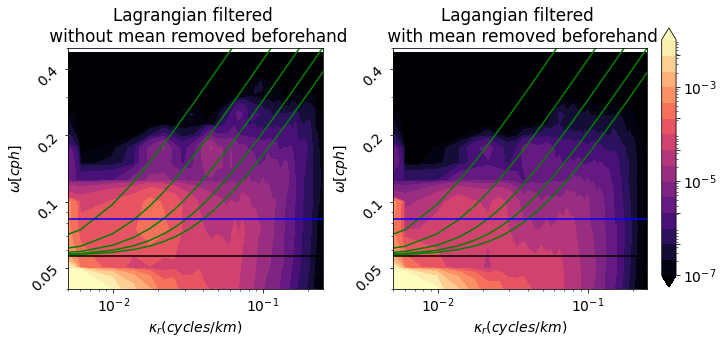

In [34]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(10,5))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-7,-2,16)
lev = np.power(10, lev_exp)

plt.subplot(121)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Lagrangian filtered \n without mean removed beforehand')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(122)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso2,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Lagangian filtered \n with mean removed beforehand')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('wavenumber_freq_eta_mean_remove.png')